# Chapter 14 Recurrent Neural Networks

Recurrent neural networks can take in sequences of arbitrary length as input, such as time series data or text. They're also capable of generating novel output. They do this by introducing the idea of networks operating in time, or having memory. 

## Recurrent Neurons

Recurrent neurons can take their output and send it back to themselves as input. We introduce the idea of a time step t and say that a neuron receives both input X<sub>(t)</sub> and output y<sub>(t-1)</sub> from the previous time step. A neuron thus has two sets of weights: one for current input and one for previous output. A *memory cell* or just a *cell*, such as a recurrent neuron, is part of a neural network that is dependent in some way on information from a previous time step. A cell also has an associated state at each time step, dependent on current input and its state from the previous time step. 

## Input and Output Sequences

There are multiple types of RNNs, when considering possible inputs and outputs. We could have a sequence as input and a sequence as output, such as using historical time series data to make forecasts. We could also have a sequence as input and a vector as output, such as classifying a document by its feeding a network its sequence of words. We could also have the reverse of this, with a vector as input and a sequence as output. Finally, we could join together a sequence to vector network with a vector to sequence network. An example of this is an Encoder-Decoder model, where we can use the encoder to convert a sequence of words into a vector which the decoder could translate into a sequence in another language.  

## Basic RNN's in TensorFlow

Our basic RNN will be made up of a cell of 5 neurons that take in vectors of 3 elements. It will also have 2 time steps, so the output of the first layer (first time step) will also be included in the input to the second layer. Every layer will have the same weights and biases because they contain the same neurons, but at a different time. We will get the output of each instance as it's gone through every neuron at every time step.

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
n_steps = 2
n_inputs= 3
n_neurons = 5

tf.reset_default_graph()

# Separate input vector for every time step in one tensor
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

# Cell made up of 5 neurons
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
# States is output at last time step for basic cell
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [15]:
init = tf.global_variables_initializer()

X_batch = np.array([
    # t=0       # t=1
    [[0, 1, 2], [9, 8, 7]], # instance 1
    [[3, 4, 5], [0, 0, 0]], # ...
    [[6, 7, 8], [6, 5, 4]], # ...
    [[9, 0, 1], [3, 2, 1]]  # instance 4
])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

# Output of 5 neurons with 4 instances and 2 time steps
print(outputs_val)
# Outputs[instance][time step][neuron]
print('\nOutput of 4th instance at 5th neuron in 2nd time step:', 
      outputs_val[3][1][4])

[[[ 0.64979637  0.8083514  -0.73296475 -0.6190548  -0.5570247 ]
  [ 0.9607432   0.9887017  -0.9994823  -0.7526373   0.87071806]]

 [[ 0.926664    0.9872352  -0.9948982  -0.86801    -0.1014521 ]
  [-0.10818524 -0.49670416  0.874287   -0.1561937  -0.64163405]]

 [[ 0.9864417   0.9992215  -0.9999151  -0.958444    0.4010542 ]
  [ 0.5496384   0.8406941  -0.95120746 -0.7192609   0.84106195]]

 [[-0.95322895 -0.89880407 -0.9997649   0.9951918   0.9999122 ]
  [-0.7791043   0.10235804 -0.8389093  -0.19287914  0.95108473]]]

Output of 4th instance at 5th neuron in 2nd time step: 0.95108473


### Handling Variable Input Length Sequences

If we have inputs with different lengths (meaning some of them don't span the entire time step), they must be zero-padded to the length of the longest sequence when they're defined, and the sequence_length parameter must be passed when constructing the RNN specifying the length of every instance. 

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs))
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

seq_length = tf.placeholder(tf.int32, shape=(None))

outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                   sequence_length=seq_length)

In [27]:
init = tf.global_variables_initializer()

X_batch = np.array([
    [[0,1,2], [3,4,5]],
    [[9,8,7], [0,0,0]], # zero padding
    [[5,6,7], [3,2,1]],
    [[4,6,8], [7,5,3]]
])

seq_len_batch = np.array([2,1,2,2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_len_batch})
    
print(f' OUTPUTS\n {outputs_val}')
print(f'\n FINAL STATES\n {states_val}')

 OUTPUTS
 [[[ 0.9005094   0.19721422 -0.74749184  0.13447112  0.35255757]
  [ 0.9959246  -0.9221021  -0.99922425 -0.00510527 -0.7015953 ]]

 [[ 0.99999094 -0.9999675  -0.9999993  -0.83891016 -0.99947757]
  [ 0.          0.          0.          0.          0.        ]]

 [[ 0.99997807 -0.9918821  -0.9999742  -0.4349029  -0.93770105]
  [ 0.9162537  -0.9960944  -0.6650218   0.7405216  -0.9781005 ]]

 [[ 0.9999938  -0.9611891  -0.9999759  -0.20734294 -0.7319394 ]
  [ 0.99696225 -0.9999669  -0.998784    0.18959737 -0.9995896 ]]]

 FINAL STATES
 [[ 0.9959246  -0.9221021  -0.99922425 -0.00510527 -0.7015953 ]
 [ 0.99999094 -0.9999675  -0.9999993  -0.83891016 -0.99947757]
 [ 0.9162537  -0.9960944  -0.6650218   0.7405216  -0.9781005 ]
 [ 0.99696225 -0.9999669  -0.998784    0.18959737 -0.9995896 ]]


### Training to Predict Time Series

Let's use RNNs to predict future values in time series data. Since the output of our RNN model at each time step will be a vector the size of the number of neurons, we'll use a fully connected layer to produce an output of the correct size after doing some reshaping.

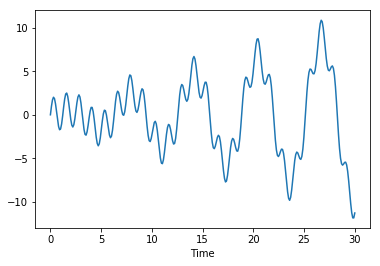

In [39]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.xlabel('Time');

In [40]:
tf.reset_default_graph()

learning_rate = 0.01

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs))
y = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs))

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# Stack all time steps on top of each other to get one output for each neuron
stacked_rnn_outputs = tf.reshape(outputs, [-1, n_neurons])
# Fully connected layer with proper number of outputs
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
# Unstack to get outputs for every neuron
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [41]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [47]:
n_iterations = 1500
batch_size = 50

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for iteration in np.arange(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, ' MSE: ', mse)
    
    # Time values
    t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)
    # Reshape to feed into network
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))        
    y_pred = sess.run(outputs, feed_dict={X: X_new})

0  MSE:  4.5465198
100  MSE:  0.12235968
200  MSE:  0.084332034
300  MSE:  0.06427125
400  MSE:  0.048832428
500  MSE:  0.051071092
600  MSE:  0.045697305
700  MSE:  0.04467769
800  MSE:  0.04656992
900  MSE:  0.049167868
1000  MSE:  0.053675525
1100  MSE:  0.0419274
1200  MSE:  0.03483821
1300  MSE:  0.037629236
1400  MSE:  0.04460977


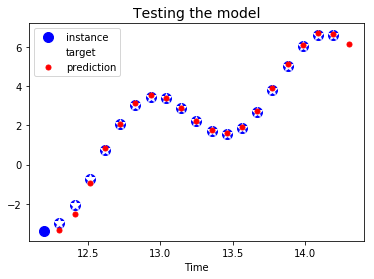

In [49]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time");

## Deep RNNs

We can also have a stack of cells at each time step instead of a single cell, called a deep RNN. Let's create a a deep RNN with 3 cells stacked on top of each other, each with 100 neurons.

In [50]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in np.arange(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Very simple!

### Applying Dropout

Let's apply dropout between RNN layers to deal with overfitting. We will use a DropoutWrapper around our cells. It has an input_keep_prob parameter to which we can pass a placeholder which will take the value of 1 during testing, to prevent dropout. 

In [55]:
tf.reset_default_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, shape=(None, n_steps, n_inputs))
y = tf.placeholder(tf.float32, shape=(None, n_steps, n_outputs))

# Use default value of 1 to prevent dropout during testing
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
        for layer in np.arange(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
             for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [56]:
# Same as before
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [57]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_iterations = 1500
batch_size = 50
# Change value during training
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 250 == 0:                   
            print(iteration, "Training MSE:", mse) 
            
    saver.save(sess, "models/my_dropout_time_series_model")

0 Training MSE: 17.587788
250 Training MSE: 3.7940028
500 Training MSE: 3.7322252
750 Training MSE: 3.1860335
1000 Training MSE: 4.476041
1250 Training MSE: 5.648244


In [58]:
with tf.Session() as sess:
    saver.restore(sess, "models/my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    # Stick with default value preventing dropout
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


## Difficulty of Training Over Many Time Steps

If we have a long sequence, RNNs may take a long time to train and are also prone to the vanishing/exploding gradient problem mentioned in earlier chapters. This seems to be particularly problematic when our sequence gets to be over 100 inputs long. Furthermore, earlier inputs also have a much smaller influence on our output than newer inputs as training continues, even if their contribution should be quite significant. Networks with long-term memory cells are made to deal with this problem.

### LSTM Cell

A Long Short-Term Memory cell has a long-term memory which can store important information for later use, or discard unimportant long-term information. It does this using three inputs: the usual input X<sub>(t)</sub>, the previous "short-term state" h<sub>(t-1)</sub>, and the previous "long-term state" c<sub>(t-1)</sub>, and three outputs: the normal y<sub>(t)</sub> and state h<sub>(t)</sub>, along with c<sub>(t)</sub>. 

The input and short term state are given as input to four fully connected layers, three of which are called *gate controllers*. Let's look at these layers:
 * main layer g<sub>(t)</sub> - analyzes current input x<sub>(t)</sub> and short term memory h<sub>(t-1)</sub> as in a basic cell, but its ouput is further controlled by the input gate 
 * forget gate f<sub>(t)</sub> - controls what information store from long term memory c<sub>(t-1)</sub>
 * input gate i<sub>(t)</sub> - controls what to store in long term memory c<sub>(t)</sub> from main layer 
 * output gate o<sub>(t)</sub> - controls what long term memory (which is a function of c<sub>(t)</sub>) to output to standard output y<sub>(t)</sub> and short-term state h<sub>(t)</sub>

These gates control the flow of information by applying the logistic activation function to a weighted sum of their inputs (current input and short-term state) plus a bias term, which outputs values from 0 to 1. These outputs are then used in element-wise multiplication with other elements of the cell, so values close to 0 will decrease the influence of these elements and values of 1 will increase their influence.

We can see that, in a sense, all the outputs are calculated by using long-term states, because these also include information about the short-term state and current inputs after these inputs flow through the cell. Looking at the equations for the outputs will make this more clear, remembering that all gates take in x<sub>(t)</sub> and h<sub>(t-1)</sub> as input. All multiplication is done element-wise.

 * c<sub>(t)</sub> = f<sub>(t)</sub> * c<sub>(t-1)</sub> + i<sub>(t)</sub> * g<sub>(t)</sub>
 * y<sub>(t)</sub> = h<sub>(t)</sub> = o<sub>(t)</sub> * tanh(c<sub>(t)</sub>)
 
#### Peephole Connections

We previously mentioned that the gates all take the current input and short-term state as inputs. However, we can add *peephole connections* to our cell if we'd like them to recieve more information, which include c<sub>(t-1)</sub> as input to the forget gate and input gate and c<sub>(t)</sub> as input to the output gate.

In [59]:
# LSTM cell with peephole connections
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, use_peepholes=True)

### Gru Cell

The Gated Recurrent Unit cell simplifies the LSTM cell but performs similarly well. In particular, the short term and long-term states are pooled into one state h<sub>(t)</sub>. The gate z<sub>(t)</sub> acts as both the input and forget gate, opening one when the closing the other (a 1 opens the input gate). The gate r<sub>(t)</sub> controls which parts of the previous state h<sub>(t-1)</sub> will be shown to the main layer (again, by performing element-wise multiplication with the output of the logistic activation function). There is no output gate. 

In [60]:
gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)